In [1]:
# Change Keras backend
from keras import backend as K
import os
os.environ['KERAS_BACKEND'] = "cntk"

In [2]:
# install dependencies
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
from keras.layers.core import Dense, Activation, Dropout
from keras.layers.recurrent import LSTM
from keras.models import Sequential
from sklearn.model_selection import  train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

In [3]:
ori_df = pd.read_csv("./gemini_BTCUSD_2015_1min.csv")
for item in range(2016,2022):
    df = pd.read_csv(f"./gemini_BTCUSD_{item}_1min.csv")
    new_df = pd.concat([ori_df,df], ignore_index=True)
    ori_df = new_df

In [4]:
ori_df.rename({"Unix Timestamp":"Timestamp"}, axis=1, inplace = True)

In [5]:
combine_df = ori_df

In [6]:
combine_df.drop_duplicates(subset=["Timestamp"], keep='first',inplace=True)

In [7]:
combine_df.head()

,Timestamp,Date,Symbol,Open,High,Low,Close,Volume
0,1451606340,2015-12-31 23:59:00,BTCUSD,429.95,429.95,429.95,429.95,0.0
1,1451606280,2015-12-31 23:58:00,BTCUSD,429.95,429.95,429.95,429.95,0.0
2,1451606220,2015-12-31 23:57:00,BTCUSD,429.95,429.95,429.95,429.95,0.0
3,1451606160,2015-12-31 23:56:00,BTCUSD,429.95,429.95,429.95,429.95,0.0
4,1451606100,2015-12-31 23:55:00,BTCUSD,429.95,429.95,429.95,429.95,0.0


In [8]:
combine_df.tail()

,Timestamp,Date,Symbol,Open,High,Low,Close,Volume
3050922,1609459440000,2021-01-01 00:04:00,BTCUSD,29056.21,29056.21,29046.04,29048.46,0.032502
3050923,1609459380000,2021-01-01 00:03:00,BTCUSD,29057.27,29057.27,29028.69,29056.21,0.049909
3050924,1609459320000,2021-01-01 00:02:00,BTCUSD,29085.38,29086.14,29043.25,29057.27,5.075271
3050925,1609459260000,2021-01-01 00:01:00,BTCUSD,29033.01,29086.14,29033.01,29085.38,1.451389
3050926,1609459200000,2021-01-01 00:00:00,BTCUSD,28979.74,29033.01,28956.18,29033.01,0.126441


In [9]:
combine_df.columns

Index(['Timestamp', 'Date', 'Symbol', 'Open', 'High', 'Low', 'Close',
       'Volume'],
      dtype='object')

In [10]:
combine_df.shape

(3050927, 8)

In [11]:
combine_df.describe()

,Timestamp,Open,High,Low,Close,Volume
count,3.050927e+06,3.050927e+06,3.050927e+06,3.050927e+06,3.050927e+06,3.050927e+06
mean,8.009380e+11,1.089527e+04,1.090162e+04,1.088885e+04,1.089529e+04,2.359846e+00
std,7.923166e+11,1.427356e+04,1.428352e+04,1.426325e+04,1.427358e+04,1.857282e+01
min,1.444312e+09,0.000000e+00,2.425000e+02,0.000000e+00,2.360000e+02,0.000000e+00
25%,1.490075e+09,1.178570e+03,1.178670e+03,1.178300e+03,1.178570e+03,0.000000e+00
50%,1.536069e+12,6.765340e+03,6.769000e+03,6.762430e+03,6.765350e+03,7.161530e-02
75%,1.586757e+12,1.042789e+04,1.043312e+04,1.042310e+04,1.042789e+04,1.031678e+00
max,1.633651e+12,6.489000e+04,6.490000e+04,6.477562e+04,6.489000e+04,8.264463e+03


In [12]:
combine_df.dtypes

Timestamp      int64
Date          object
Symbol        object
Open         float64
High         float64
Low          float64
Close        float64
Volume       float64
dtype: object

In [13]:
combine_df.set_index('Timestamp', inplace=True)
combine_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3050927 entries, 1451606340 to 1609459200000
Data columns (total 7 columns):
 #   Column  Dtype  
---  ------  -----  
 0   Date    object 
 1   Symbol  object 
 2   Open    float64
 3   High    float64
 4   Low     float64
 5   Close   float64
 6   Volume  float64
dtypes: float64(5), object(2)
memory usage: 186.2+ MB


In [14]:
combine_df.sort_index(inplace=True)

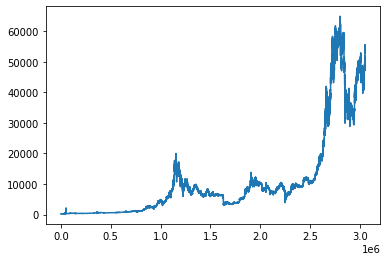

In [15]:
data_close = combine_df['Close']
data_close = data_close.values.reshape(len(data_close), 1)
plt.plot(data_close)
plt.show()

In [16]:
# normalise data
scaler = MinMaxScaler(feature_range=(0,1))

In [17]:
data_close = scaler.fit_transform(data_close)
data_close

array([[1.00535156e-04],
       [1.07495283e-04],
       [1.07495283e-04],
       ...,
       [8.28160052e-01],
       [8.27606181e-01],
       [8.28841680e-01]])

In [18]:
# split data into train and test
train_size = int(len(data_close)*0.7)
test_size = len(data_close) - train_size

data_train, data_test = data_close[0:train_size, :], data_close[train_size:len(data_close), :]
print('Split data into train and test: ', len(data_train), len(data_test))

Split data into train and test:  2135648 915279


In [19]:
# need to now convert the data into time series looking back over a period of days...e.g. use last 7 days to predict price
def create_ts(ds, series):
    X, Y =[], []
    for i in range(len(ds)-series - 1):
        item = ds[i:(i+series), 0]
        X.append(item)
        Y.append(ds[i+series, 0])
    return np.array(X), np.array(Y)

series = 7

trainX, trainY = create_ts(data_train, series)
testX, testY = create_ts(data_test, series)

In [20]:
trainX

array([[1.00535156e-04, 1.07495283e-04, 1.07495283e-04, ...,
        1.07649952e-04, 1.07649952e-04, 1.07649952e-04],
       [1.07495283e-04, 1.07495283e-04, 1.07649952e-04, ...,
        1.07649952e-04, 1.07649952e-04, 1.07649952e-04],
       [1.07495283e-04, 1.07649952e-04, 1.07649952e-04, ...,
        1.07649952e-04, 1.07649952e-04, 1.07649952e-04],
       ...,
       [1.12202029e-01, 1.12202029e-01, 1.12274569e-01, ...,
        1.12417484e-01, 1.12453367e-01, 1.12458935e-01],
       [1.12202029e-01, 1.12274569e-01, 1.12274569e-01, ...,
        1.12453367e-01, 1.12458935e-01, 1.12458935e-01],
       [1.12274569e-01, 1.12274569e-01, 1.12417484e-01, ...,
        1.12458935e-01, 1.12458935e-01, 1.12428929e-01]])

In [21]:
trainX[0]

array([0.00010054, 0.0001075 , 0.0001075 , 0.00010765, 0.00010765,
       0.00010765, 0.00010765])

In [22]:
# reshape into  LSTM format - samples, steps, features
trainX = np.reshape(trainX, (trainX.shape[0], trainX.shape[1], 1))
testX = np.reshape(testX, (testX.shape[0], testX.shape[1], 1))

In [23]:
# build the model
model = Sequential()
model.add(LSTM(4, input_shape=(series, 1)))
model.add(Dense(1))
model.compile(loss='mse', optimizer='adam')
# fit the model
model.fit(trainX, trainY, epochs=100, batch_size=32)

2021-12-02 16:53:08.274693: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2021-12-02 16:53:10.568288: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/100
66739/66739 [==============================] - 765s 11ms/step - loss: 7.2818e-06
Epoch 2/100
66739/66739 [==============================] - 1992s 30ms/step - loss: 7.3718e-08
Epoch 3/100
66739/66739 [==============================] - 680s 10ms/step - loss: 5.9219e-08
Epoch 4/100
66739/66739 [==============================] - 651s 10ms/step - loss: 4.9926e-08
Epoch 5/100
66739/66739 [==============================] - 732s 11ms/step - loss: 4.5182e-08
Epoch 6/100
66739/66739 [==============================] - 779s 12ms/step - loss: 4.2978e-08
Epoch 7/100
66739/66739 [==============================] - 678s 10ms/step - loss: 4.1634e-08
Epoch 8/100
66739/66739 [==============================] - 742s 11ms/step - loss: 4.1229e-08
Epoch 9/100
66739/66739 [==============================] - 675s 10ms/step - loss: 4.0751e-08
Epoch 10/100
66739/66739 [==============================] - 722s 11ms/step - loss: 4.0552e-08
Epoch 11/100
66739/66739 [==============================] - 794s 12m

KeyboardInterrupt: 

In [ ]:
# test this model out
trainPredictions = model.predict(trainX)
testPredictions = model.predict(testX)

# unscale predictions
trainPredictions = scaler.inverse_transform(trainPredictions)
testPredictions = scaler.inverse_transform(testPredictions)
trainY = scaler.inverse_transform([trainY])
testY = scaler.inverse_transform([testY])

In [ ]:
# lets calculate the root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredictions[:, 0]))
testScore = math.sqrt(mean_squared_error(testY[0], testPredictions[:, 0]))
print('Train score: %.2f rmse', trainScore)
print('Test score: %.2f rmse', testScore)

In [ ]:
# lets plot the predictions on a graph and see how well it did
train_plot = np.empty_like(data_close)
train_plot[:,:] = np.nan
train_plot[series:len(trainPredictions)+series, :] = trainPredictions

test_plot = np.empty_like(data_close)
test_plot[:,:] = np.nan
test_plot[len(trainPredictions)+(series*2)+1:len(data_close)-1, :] = testPredictions

# plot on graph
plt.plot(scaler.inverse_transform(data_close))
plt.plot(train_plot)
plt.plot(test_plot)
plt.show()